# Semantic Segmentation for Self-Driving Perception

In [ ]:
# Dataset download

!pip install -q kaggle
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge
!unzip lyft-udacity-challenge.zip

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current environment is using:", device)

Current environment is using: cuda


In [21]:
def display_images(data, no_img_mask):

    # Load the images from the files
    images = glob.glob(data+'/'+data+'/CameraRGB/*.png')[:no_img_mask]
    masks = glob.glob(data+'/'+data+'/CameraSeg/*.png')[:no_img_mask]

    for i in range(len(images)):
        images[i] = cv2.imread(images[i])
        masks[i] = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)



    fig, axes = plt.subplots(no_img_mask, 2)
    plt.axis('off')
    for i in range(len(images)):
        axes[i][0].imshow(images[i], cmap='viridis')
        axes[i][1].imshow(masks[i], cmap='viridis')
        axes[i][0].axis('off')
        axes[i][1].axis('off')



    plt.show()

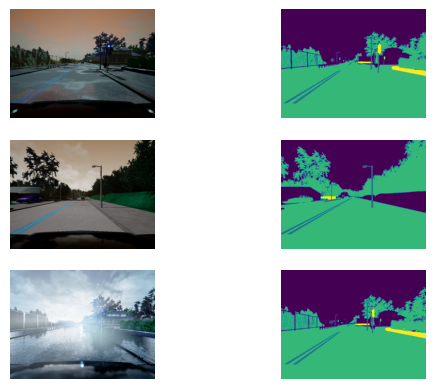

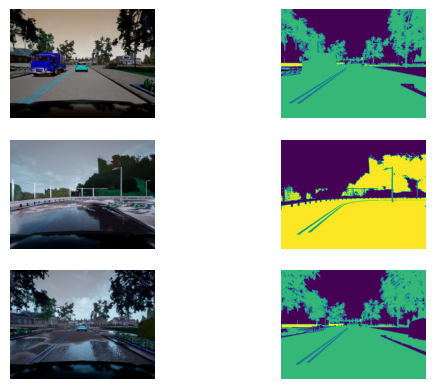

In [22]:
display_images('dataA', 3)
display_images('dataB', 3)


In [5]:
letters=['A','B','C','D','E']
imgs_list=[]
masks_list=[]
for i in letters:
  imgs_list.append(glob.glob('data'+i+'/'+'data'+i+'/CameraRGB/*.png'))
  masks_list.append(glob.glob('data'+i+'/'+'data'+i+'/CameraSeg/*.png'))

print(imgs_list[0][:10],'\n')
print(imgs_list[1][:10],'\n')

print(masks_list[0][:10])
print(masks_list[1][:10])

['dataA/dataA/CameraRGB/07_00_020.png', 'dataA/dataA/CameraRGB/10_00_010.png', 'dataA/dataA/CameraRGB/F5-31.png', 'dataA/dataA/CameraRGB/07_00_191.png', 'dataA/dataA/CameraRGB/07_00_071.png', 'dataA/dataA/CameraRGB/05_00_151.png', 'dataA/dataA/CameraRGB/06_00_211.png', 'dataA/dataA/CameraRGB/04_00_020.png', 'dataA/dataA/CameraRGB/03_00_190.png', 'dataA/dataA/CameraRGB/03_00_021.png'] 

['dataB/dataB/CameraRGB/02_02_143.png', 'dataB/dataB/CameraRGB/F69-23.png', 'dataB/dataB/CameraRGB/F61-53.png', 'dataB/dataB/CameraRGB/03_01_233.png', 'dataB/dataB/CameraRGB/02_00_022.png', 'dataB/dataB/CameraRGB/09_00_113.png', 'dataB/dataB/CameraRGB/07_00_222.png', 'dataB/dataB/CameraRGB/10_00_023.png', 'dataB/dataB/CameraRGB/08_00_233.png', 'dataB/dataB/CameraRGB/F61-92.png'] 

['dataA/dataA/CameraSeg/07_00_020.png', 'dataA/dataA/CameraSeg/10_00_010.png', 'dataA/dataA/CameraSeg/F5-31.png', 'dataA/dataA/CameraSeg/07_00_191.png', 'dataA/dataA/CameraSeg/07_00_071.png', 'dataA/dataA/CameraSeg/05_00_151.pn

In [6]:
def get_one_list(list_of_lists):

    one_list = []

    for sublist in list_of_lists:
        one_list.extend(sublist)
    return one_list

imgs_list = get_one_list(imgs_list)
masks_list = get_one_list(masks_list)

print(imgs_list[50], '\n')
print(masks_list[50], '\n')



dataA/dataA/CameraRGB/F69-11.png 

dataA/dataA/CameraSeg/F69-11.png 



Image shape: torch.Size([1, 3, 192, 256])
Mask shape: torch.Size([1, 192, 256])
Unique values in mask: tensor([0, 1, 2, 3, 4])
Unique values in mask: tensor([0, 1, 2, 3, 4])


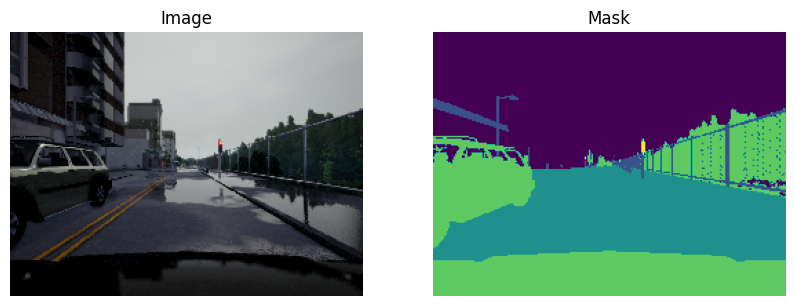

In [7]:
class DriveDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = sorted(image_paths)
        self.mask_paths = sorted(mask_paths)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask from file paths
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Use PIL to load the images and masks
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale (single-channel)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

# Transform functions for resizing and converting to tensors
class Preprocess:
    def __init__(self, img_size=(192, 256)):
        self.img_size = img_size
        self.resize = transforms.Resize(self.img_size, interpolation=Image.NEAREST)
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, mask):
        image = self.resize(image)
        mask = self.resize(mask)


        image = self.to_tensor(image)

        # Convert mask to a numpy array, then tensor with integer class labels
        mask = torch.as_tensor(np.array(mask), dtype=torch.long)  # Mask should be in long format for CrossEntropyLoss

        return image, mask


image_filenames = imgs_list  # List of image file paths
masks_filenames = masks_list  # List of mask file paths


preprocess = Preprocess()
dataset = DriveDataset(image_filenames, masks_filenames, transform=preprocess)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Iterate through the dataset and print the first image and mask pair
for image, mask in dataloader:
    print("Image shape:", image.shape)  # Image tensor: 3 channels for RGB images
    print("Mask shape:", mask.shape)   # Mask tensor: should be [batch_size, height, width] (no need for squeezing)
    print("Unique values in mask:", torch.unique(mask))  # Check the unique values in the mask
    break



# Test

for images, masks in dataloader:
    # Print unique values in the mask to ensure it's correctly loaded
    print("Unique values in mask:", torch.unique(masks))

    # Visualize the image and the mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images.squeeze(0).permute(1, 2, 0).numpy())  # Squeeze batch, permute for correct RGB order
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks.squeeze(0).cpu(), cmap='viridis')  # Visualize the mask correctly
    plt.title('Mask')
    plt.axis('off')

    plt.show()

    break


In [8]:
## Create an empty set to store unique mask values
#uniques = set()
#
## Iterate through the dataset and collect unique mask values
#for image, mask in dataloader:
#    # Convert the mask tensor to a NumPy array
#    mask_np = mask.numpy()
#
#    # Update the set with unique values from the mask
#    uniques.update(np.unique(mask_np))
#
#    if len(uniques) > 5000:
#       break
#
#print(uniques)


#{0.0, 0.003921569, 0.019607844, 0.007843138, 0.011764706, 0.023529412, 0.02745098, 0.03137255, 0.03529412, 0.039215688, 0.043137256, 0.047058824, 0.015686275}

## U-Net Architecture

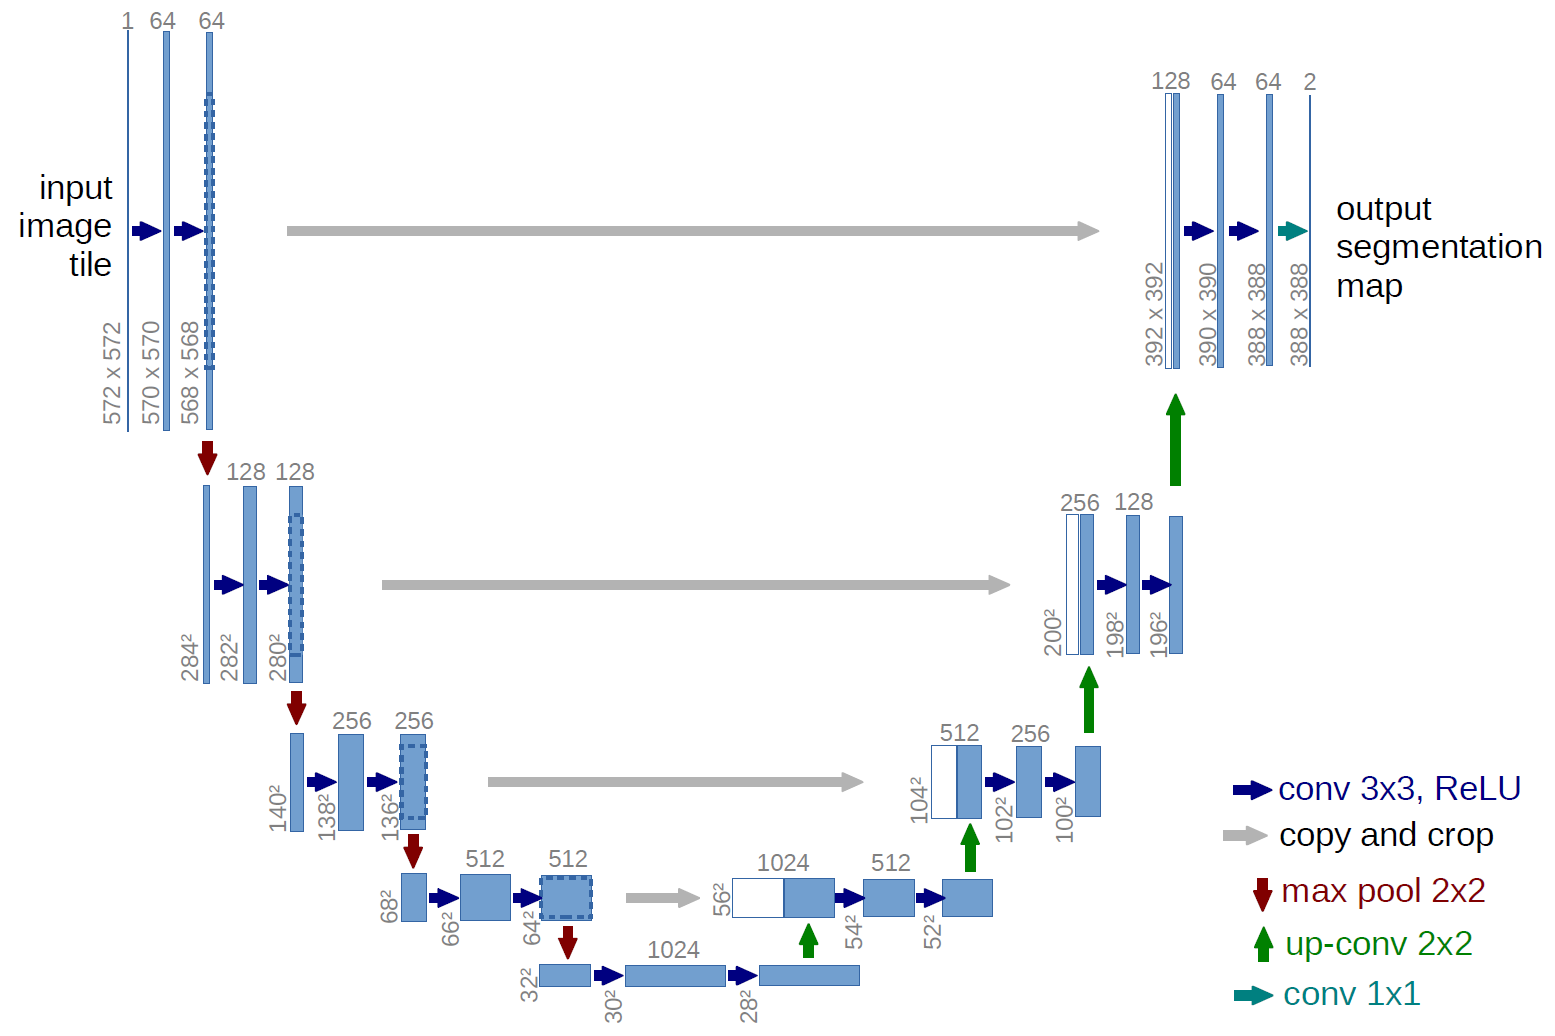

In [9]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3,1,1, bias=False), # same convolution
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, 3,1,1, bias=False), # same convolution
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=13, features=[64, 128, 256, 512]):  # out_channels to the number of classes
        super(UNet, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # UNET down stage
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # UNET up stage
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,  # doubles h, w of image
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # For multi-class, ensure final output has out_channels = number of classes
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse list of skip connection

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)




# Example testing for 13 classes
def test():
    x = torch.randn((3, 1, 173, 173))  # Input tensor
    model = UNet(in_channels=1, out_channels=13)  # Assuming 13 classes
    preds = model(x)
    print(preds.shape)
    assert preds.shape == (3, 13, 173, 173)  # Expecting 13 classes for the output

test()

torch.Size([3, 13, 173, 173])


In [10]:
num_samples = len(dataset)

train_size = int(0.8 * num_samples)

val_size = num_samples - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [11]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = 13 # 13 classes in the dataset

model = UNet(in_channels=3, out_channels=num_classes, features=[64, 128, 256, 512])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, min_lr=1e-6)

In [12]:
# Load Model

#model = UNet(in_channels=3, out_channels=num_classes, features=[64, 128, 256, 512])
#model.load_state_dict(torch.load('best_model.pth'))
#model.to(device)

In [23]:
EPOCHS = 10
patience = 2
best_loss = float('inf')
early_stop_counter = 0

model = model.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    correct_pixels = 0
    total_pixels = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Ensure masks have the correct shape

        optimizer.zero_grad() # Ensure gradients from previous batches don't affect current batch's gradient calculation

        outputs = model(images)
        #print(masks)
        masks = masks.squeeze(1)
        #print(masks)

        # Compute the loss
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy for training batch
        predicted_mask = torch.argmax(outputs, dim=1)
        correct_pixels += (predicted_mask == masks).sum().item()
        total_pixels += masks.numel()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    accuracy = correct_pixels / total_pixels
    train_accuracies.append(accuracy)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct_pixels = 0
    val_total_pixels = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            # Calculate validation accuracy
            predicted_mask = torch.argmax(outputs, dim=1)
            val_correct_pixels += (predicted_mask == masks).sum().item()
            val_total_pixels += masks.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = val_correct_pixels / val_total_pixels
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'unet_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break


Epoch [1/10], Loss: 0.1451, Accuracy: 0.9704
Validation Loss: 0.1227, Validation Accuracy: 0.9729
Epoch [2/10], Loss: 0.1108, Accuracy: 0.9746
Validation Loss: 0.1003, Validation Accuracy: 0.9760
Epoch [3/10], Loss: 0.0932, Accuracy: 0.9763
Validation Loss: 0.0901, Validation Accuracy: 0.9763
Epoch [4/10], Loss: 0.0798, Accuracy: 0.9782
Validation Loss: 0.0767, Validation Accuracy: 0.9781
Epoch [5/10], Loss: 0.0665, Accuracy: 0.9810
Validation Loss: 0.0618, Validation Accuracy: 0.9819
Epoch [6/10], Loss: 0.0574, Accuracy: 0.9830
Validation Loss: 0.0577, Validation Accuracy: 0.9824
Epoch [7/10], Loss: 0.0567, Accuracy: 0.9824
Validation Loss: 0.0525, Validation Accuracy: 0.9836
Epoch [8/10], Loss: 0.0462, Accuracy: 0.9855
Validation Loss: 0.0468, Validation Accuracy: 0.9850
Epoch [9/10], Loss: 0.0419, Accuracy: 0.9865
Validation Loss: 0.0448, Validation Accuracy: 0.9856
Epoch [10/10], Loss: 0.0387, Accuracy: 0.9873
Validation Loss: 0.0419, Validation Accuracy: 0.9862


In [28]:
torch.save(model.state_dict(), 'unet_model.pth')

In [ ]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
def calculate_pixel_accuracy(pred, true):
    correct = (pred == true).sum().item()
    total = true.numel()
    return correct / total

# After visualizing the image, true mask, and predicted mask:
predicted_mask = torch.argmax(outputs, dim=1)
accuracy = calculate_pixel_accuracy(predicted_mask, masks)

print(f"Prediction Pixel Accuracy: {accuracy:.4f}")


Prediction Pixel Accuracy: 0.9898


In [26]:
def calculate_iou(pred, true, num_classes):
    iou_per_class = []
    for cls in range(num_classes):
        intersection = torch.logical_and(pred == cls, true == cls).sum().item()
        union = torch.logical_or(pred == cls, true == cls).sum().item()
        if union == 0:
            iou_per_class.append(float('nan'))  # Ignore this class
        else:
            iou_per_class.append(intersection / union)
    return np.nanmean(iou_per_class)

# After visualizing the mask:
iou = calculate_iou(predicted_mask, masks, num_classes=4)
print(f"Prediction IoU: {iou:.4f}")


Prediction IoU: 0.9396


Predicted mask unique values: tensor([0, 1, 2, 3], device='cuda:0')


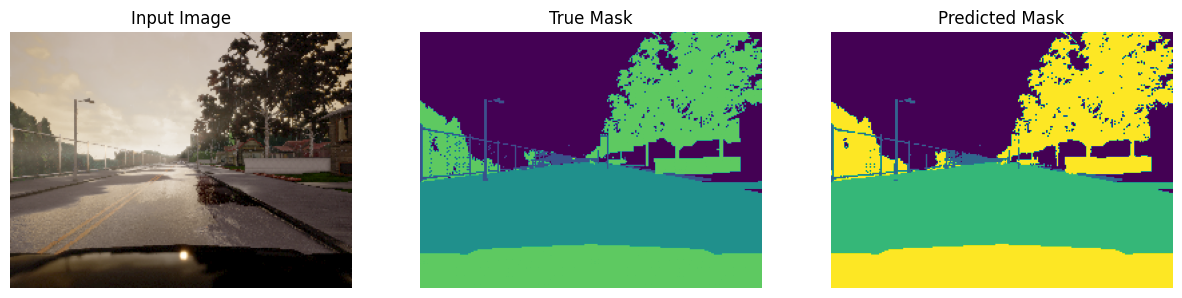

Predicted mask unique values: tensor([0, 1, 2, 3], device='cuda:0')


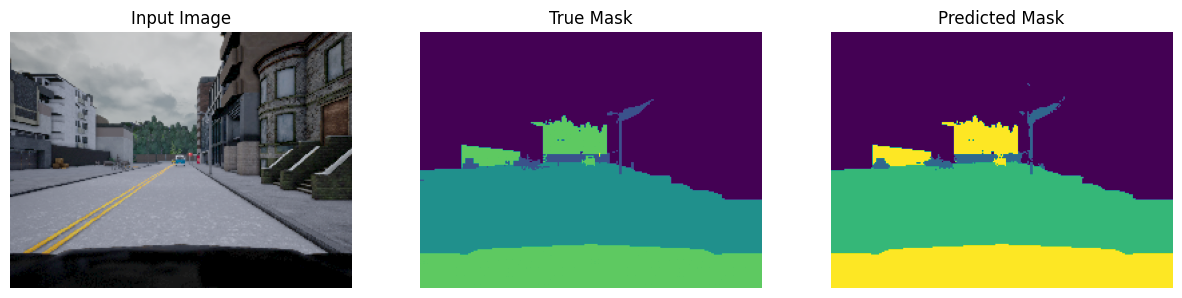

Predicted mask unique values: tensor([0, 1, 2, 3], device='cuda:0')


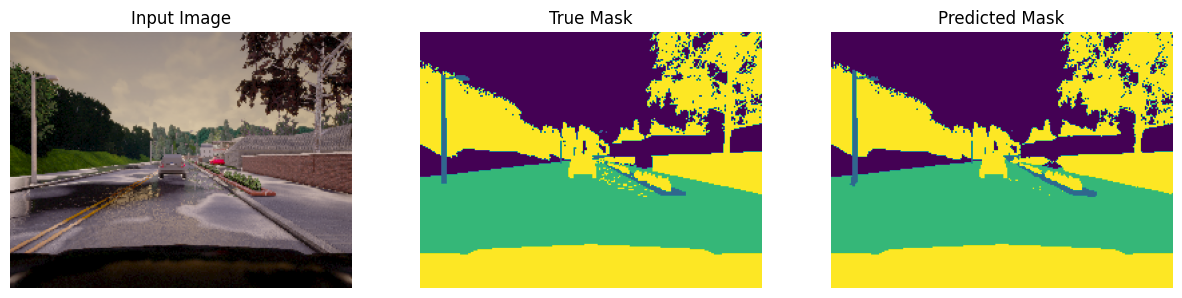

Predicted mask unique values: tensor([0, 1, 2, 3, 4], device='cuda:0')


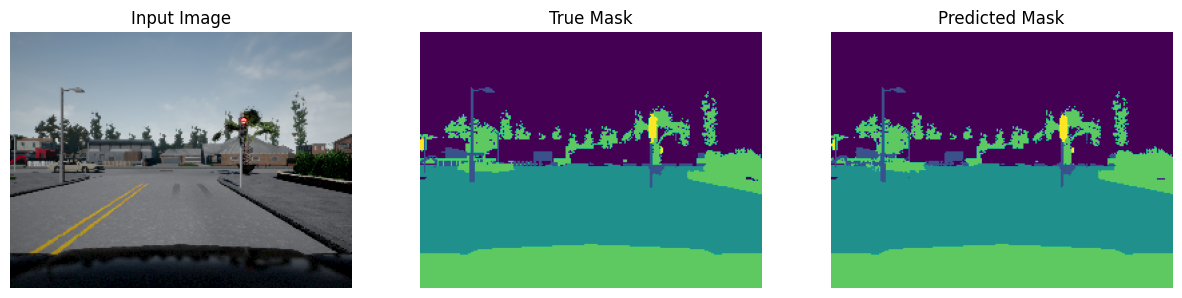

Predicted mask unique values: tensor([0, 1, 2, 3, 4], device='cuda:0')


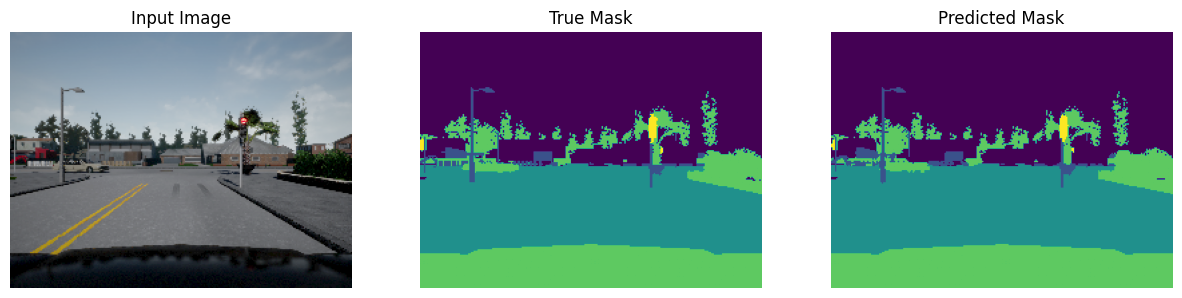

Predicted mask unique values: tensor([0, 1, 2, 3], device='cuda:0')


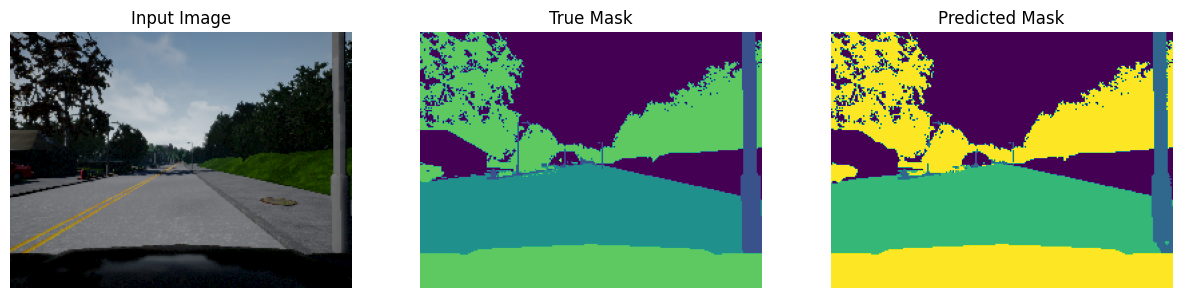

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to create a mask from model predictions
def create_mask(pred_mask):
    #print("Raw Predictions:", pred_mask)
    pred_mask_prob = torch.softmax(pred_mask, dim=1)  # Apply softmax to get probabilities
    #print("Softmax Probabilities:", pred_mask_prob)
    pred_mask_class = torch.argmax(pred_mask_prob, dim=1)  # Take argmax to get predicted classes
    #print("Predicted Mask Classes:", pred_mask_class)
    return pred_mask_class[0]  # Return the first image in the batch

# Function to display images
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])

        img = display_list[i].cpu().numpy()

        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))  # From [C, H, W] to [H, W, C]
            plt.imshow(img)
        else:
            if i == 1 or i == 2:  # True and Predicted Masks
                plt.imshow(img.squeeze(), cmap='viridis')  # Use colormap for masks
            else:
                plt.imshow(img.squeeze(), cmap='viridis')  # Default grayscale for images
        plt.axis('off')

    plt.show()

# Function to show model predictions
def show_predictions(model, dataloader, num=1, device='cpu'):
    model.eval()  # Set model to evaluation mode

    for idx, (image, true_mask) in enumerate(dataloader):
        if idx >= num:
            break

        image, true_mask = image.to(device), true_mask.to(device)

        with torch.no_grad():
            output = model(image)

        pred_mask = create_mask(output)

        # Debugging prints for mask values
        print(f"Predicted mask unique values: {torch.unique(pred_mask)}")

        # Display the input image, true mask, and predicted mask
        display([image[0], true_mask[0], pred_mask])



# Example usage: Assuming model, val_loader, and device are defined
show_predictions(model, val_loader, num=6, device=device)


